In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

In [39]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('../../src', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import SequentialDeepONetDataset
from helper import  convert2dim, train_val_test_split, fit, compute_metrics_region, load_model_experiment

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Load Datasets

In [40]:
# input data shape (8400, 12)
# trunk shape (361 * 181, 2)
# target shape (8400, 361 * 181)

#input_data = np.random.randn(8400, 12)        
#trunk = np.random.randn(361 * 181, 2)        
#target = np.random.randn(8400, 361 * 181)

input_data = np.load('../../data/neutron_data_22yrs.npy')
trunk = np.load('../../data/grid_points.npy')
target = np.load('../../data/dose_array.npy')

print("Input data shape:", input_data.shape)
print("Trunk shape:", trunk.shape)
print("Target shape:", target.shape)

Input data shape: (8400, 12)
Trunk shape: (65341, 2)
Target shape: (8400, 65341)


In [41]:
from forecasting_analysis import create_windows_forecasting_with_index

In [42]:
dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")

W, H = 30, 1
X_all, y_all, tgt_idx = create_windows_forecasting_with_index(input_data, target, W, H)
tgt_dates = dates[tgt_idx]

train_mask = (tgt_dates <= pd.Timestamp("2021-12-31"))
val_mask   = (tgt_dates >= pd.Timestamp("2022-01-01")) & (tgt_dates <= pd.Timestamp("2022-12-31"))
test_mask  = (tgt_dates >= pd.Timestamp("2023-01-01")) & (tgt_dates <= pd.Timestamp("2023-12-31"))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# check shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: torch.Size([7640, 30, 12]) torch.Size([7640, 65341])
Validation set: torch.Size([365, 30, 12]) torch.Size([365, 65341])
Test set: torch.Size([365, 30, 12]) torch.Size([365, 65341])


In [73]:
# first_test_idx = np.where(test_mask)[0][0]
# print("First test target date:", tgt_dates[first_test_idx])
# print("Input window covers:",
#       dates[first_test_idx : first_test_idx + W])

In [43]:
scaler_input = MinMaxScaler()
X_train_scaled = scaler_input.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled   = scaler_input.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled  = scaler_input.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [44]:
scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)[..., np.newaxis]
y_val_scaled   = scaler_target.transform(y_val)[..., np.newaxis]
y_test_scaled  = scaler_target.transform(y_test)[..., np.newaxis]

In [45]:
# create datasets
#train_dataset = SequentialDeepONetDataset(X_train, trunk, y_train_scaled)
#val_dataset   = SequentialDeepONetDataset(X_val, trunk, y_val_scaled)
#test_dataset  = SequentialDeepONetDataset(X_test, trunk, y_test_scaled)

train_dataset = SequentialDeepONetDataset(X_train_scaled, trunk, y_train_scaled)
val_dataset   = SequentialDeepONetDataset(X_val_scaled,   trunk, y_val_scaled)
test_dataset  = SequentialDeepONetDataset(X_test_scaled,  trunk, y_test_scaled)

# create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## TRON

In [46]:
from helper import init_model
from forecasting_analysis import train_model

In [47]:
model = init_model()

In [48]:
# history = train_model(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     scaler_target=scaler_target,
#     num_epochs=200,
#     lr=1e-3,
#     weight_decay=1e-4,
#     scheduler_step=20,
#     scheduler_gamma=0.7,
#     early_stop_patience=20,
#     save_path="inp_scale_tron_forecast.pt"
# )


In [49]:
# save history
import pickle
# with open('training_history.pkl', 'wb') as f:
#     pickle.dump(history, f)
    
# how to load history
def load_history(path, plot=True):
    with open(path, 'rb') as f:
        history = pickle.load(f)

    if plot:
        fig, ax = plt.subplots(1,1, figsize=(8,6))
        ax.plot(history['train_loss'], label='Train Loss')
        ax.plot(history['val_loss'], label='Validation Loss')
        ax.set_yscale('log')
        ax.legend()
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training History')
        plt.show()
    else:
        return history

    return 0

history = load_history('training_history.pkl', plot=False)

In [50]:
model = load_model_experiment(model_path = 'inp_scale_tron_forecast.pt')

outputs, targets = fit(model.to(device), test_loader, device, scaler_target)

Loaded model from inp_scale_tron_forecast.pt


In [51]:
lon_grid, lat_grid, pred_img = convert2dim(outputs, grid_path='../../data/grid_points.npy')  # (N,H,W)
_,        _,        targ_img = convert2dim(targets, grid_path='../../data/grid_points.npy')  # (N,H,W)

print("Prediction image shape:", pred_img.shape)
print("Target image shape:", targ_img.shape)

Prediction image shape: (365, 181, 361)
Target image shape: (365, 181, 361)


In [52]:
l2, ssim = compute_metrics_region(pred_img, targ_img, lon_grid, lat_grid, region_extent=[-180, 180, -90, 90])

Region [-180, 180, -90, 90]
Mean rel-L2 (%): 1.1400301
Mean SSIM: 0.9020130729412428


In [84]:
# 365 days covering 2023 test period
dates = pd.date_range("2023-01-01", "2023-12-31", freq="D")

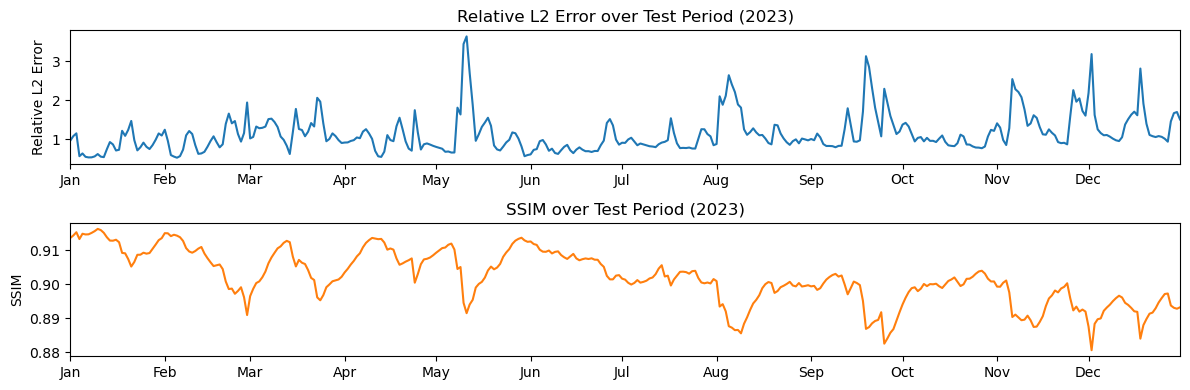

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# 365 days covering 2023 test period
#dates = pd.date_range("2023-01-01", "2023-12-31", freq="D")

fig, ax = plt.subplots(2, 1, figsize=(12, 4))
fig.subplots_adjust(hspace=0.4)

# --- L2 Error plot ---
ax[0].plot(dates, l2, label='L2 Error')
ax[0].set_title('Relative L2 Error over Test Period (2023)')
ax[0].set_ylabel('Relative L2 Error')
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # month abbreviations (Jan, Feb, ...)
ax[0].tick_params(axis='x', rotation=0)

# --- SSIM plot ---
ax[1].plot(dates, ssim, label='SSIM', color='tab:orange')
ax[1].set_title('SSIM over Test Period (2023)')
ax[1].set_ylabel('SSIM')
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].tick_params(axis='x', rotation=0)

# set xlim (january 1, 2023 to december 31, 2023)
ax[0].set_xlim(dates[0], dates[-1])
ax[1].set_xlim(dates[0], dates[-1])

plt.tight_layout()
plt.show()
